## Problem statement:
##### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [26]:
# Installing Augmentor library
!pip install Augmentor

## Importing all the important libraries

In [58]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from glob import glob
import Augmentor

#### conneting to google drive to access data

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
## validating if we are able to  coonect and list data drives
!ls /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/

Test  Train


*This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.*



---





### Importing Skin Cancer Data

In [31]:
##  Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Test')

In [32]:
# number of train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

*Let's load these images off disk using the helpful image_dataset_from_directory utility.*

### Create a dataset

*Define some parameters for the loader:*

In [33]:
# Defining batch size, image height and image width which we will use in this assigment.
batch_size = 32
img_height = 180
img_width = 180

In [34]:
# Function to load datasets
# Using 80% of the images for training, and 20% for validation.
def load_datasets(data_dir_train,data_dir_test):
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  batch_size = batch_size,
  image_size = (img_height, img_width)
  )

  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "validation",
    batch_size = batch_size,
    image_size = (img_height, img_width)
  )
  class_names = train_ds.class_names
  num_classes = len(class_names)
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return (train_ds, val_ds, class_names,num_classes)

In [35]:
# Load dataset
train_ds, val_ds, class_names,num_classes = load_datasets(data_dir_train,data_dir_test)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [36]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [46]:
# function to visualize performance during training

def plot_accuracy_and_loss(history,epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

### Visualize the data
####create a code to visualize one instance of all the nine classes present in the dataset

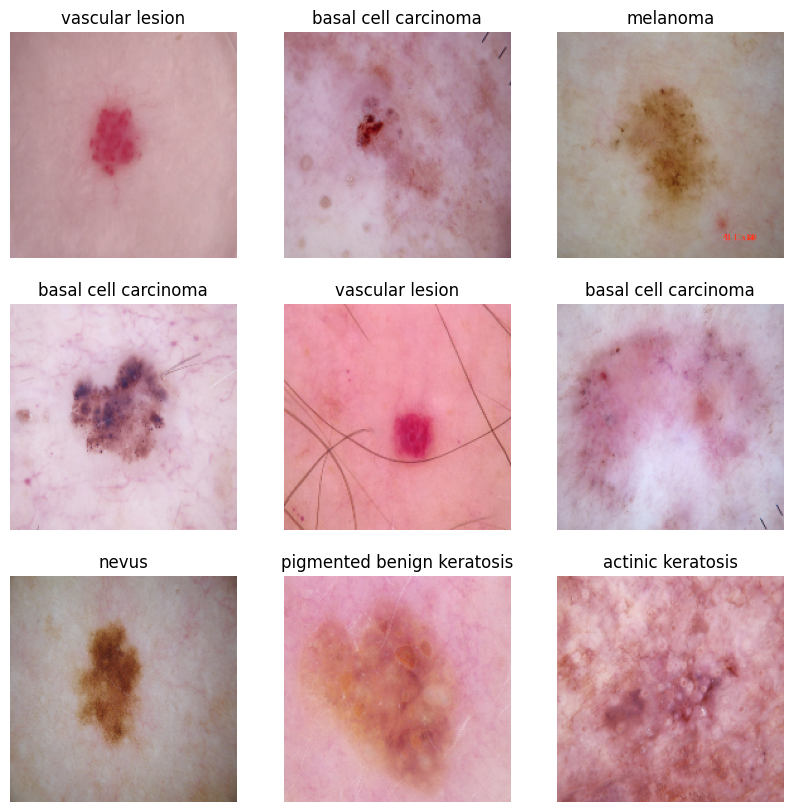

In [40]:
# Visualize one instance of all the nine classes present in the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```tf.keras.layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [41]:
# First model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(64,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(128,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [43]:
###  compile the model
optimizer = 'adam'
loss = 'sparse_categorical_crossentropy'
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [44]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [27]:
train_ds,val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [45]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 289s 5s/step - accuracy: 0.2170 - loss: 2.2749 - val_accuracy: 0.3557 - val_loss: 1.7888
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.4049 - loss: 1.6644 - val_accuracy: 0.4698 - val_loss: 1.5481
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.4747 - loss: 1.4633 - val_accuracy: 0.5168 - val_loss: 1.4432
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.5478 - loss: 1.2894 - val_accuracy: 0.4944 - val_loss: 1.4164
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.5524 - loss: 1.2518 - val_accuracy: 0.5414 - val_loss: 1.3402
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.5818 - loss: 1.1511 - val_accuracy: 0.5235 - val_loss: 1.5188
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.6208 - loss: 1.0851 - val_accuracy: 0.5414 - val_loss: 1.3547
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.6711 - loss: 0.9184 - val_accuracy: 0.5369 - v

### Visualizing training results

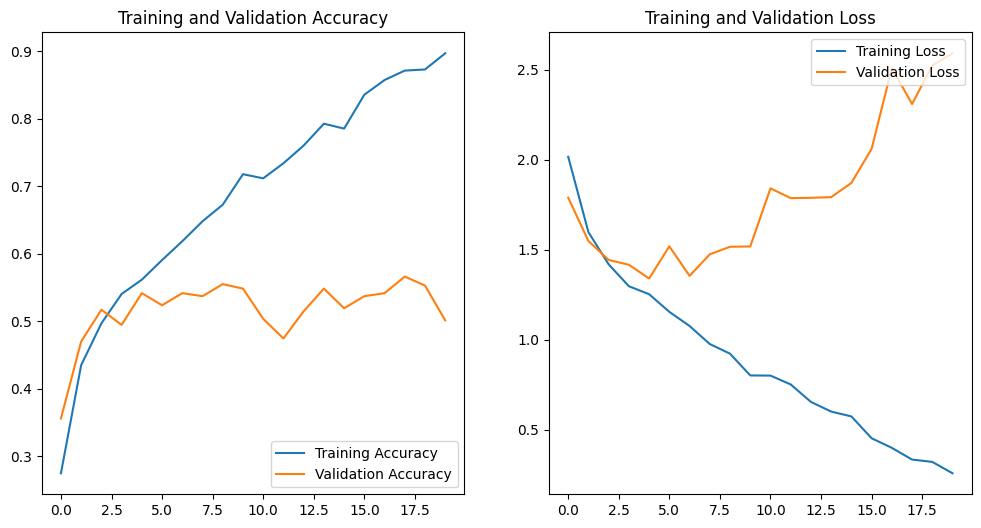

In [47]:
# Plot training performance
plot_accuracy_and_loss(history,epochs)

### Observation
1) The model's training accuracy shows a steady increase of upto 91%, while validation accuracy is around 50%

2) A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

3) These observations confirm the presence of overfitting.

### Solution
- We will try below techniqies to deal with overfitting
  - Reducing model complexity (number of layers, number of neurons)
  - Applying regularization (Dropout layers)
  - Batch Normalization
  - Data Augmentation


In [51]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = keras.Sequential([
                                      tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      tf.keras.layers.RandomRotation(0.1),
                                       tf.keras.layers.RandomZoom(0.1),
])

## Visualize augmented image for one sample

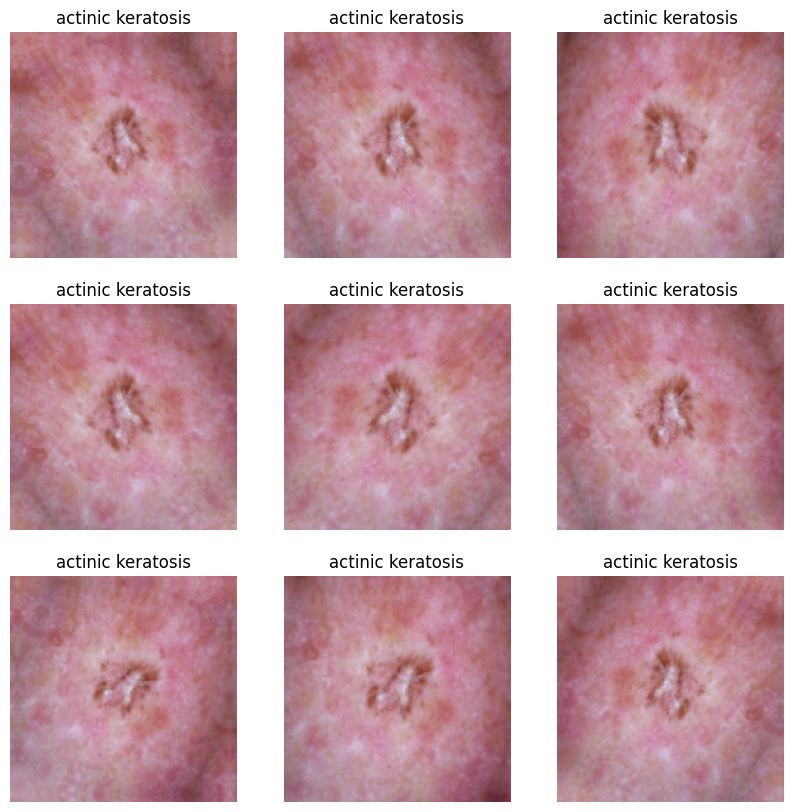

In [52]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Create the model, compile and train the model

In [53]:
# Create a model With reduced layers, reduced neurons, data augmentation layer and dropout layer to get rid of overfitting
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  augmentation_data,
  layers.Conv2D(16,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [54]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [55]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1710 - loss: 2.9121 - val_accuracy: 0.3512 - val_loss: 1.9258
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3142 - loss: 1.9059 - val_accuracy: 0.3557 - val_loss: 1.7655
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.3798 - loss: 1.7385 - val_accuracy: 0.4452 - val_loss: 1.6614
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.4036 - loss: 1.6775 - val_accuracy: 0.4295 - val_loss: 1.5853
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4479 - loss: 1.5899 - val_accuracy: 0.4273 - val_loss: 1.5558
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.4253 - loss: 1.5876 - val_accuracy: 0.4922 - val_loss: 1.4883
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5082 - loss: 1.4827 - val_accuracy: 0.4273 - val_loss: 1.5680
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4810 - loss: 1.4482 - val_accuracy: 0.4765 - val_loss:

### Visualizing training results

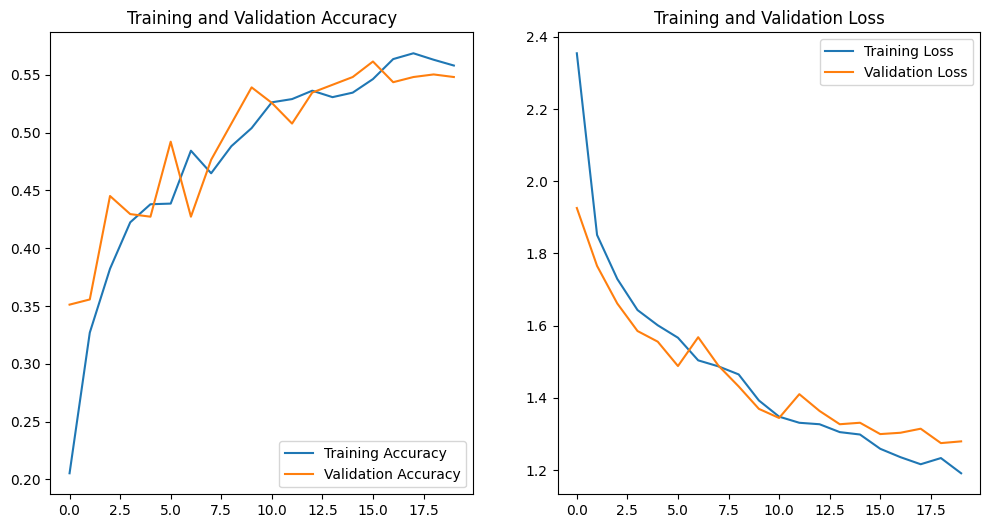

In [56]:
# Plot training performance
plot_accuracy_and_loss(history,epochs)

## Observations:

1) By reducing layers, reducing  neurons, using data augmentation layer and dropout layer overfitting has been effectively addressed.

2) Difference between training and validation loss is reduced

3) Both the training and validation data are showing poor performance (accuracy of 54%), indicating that the model is now exhibiting underfitting.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

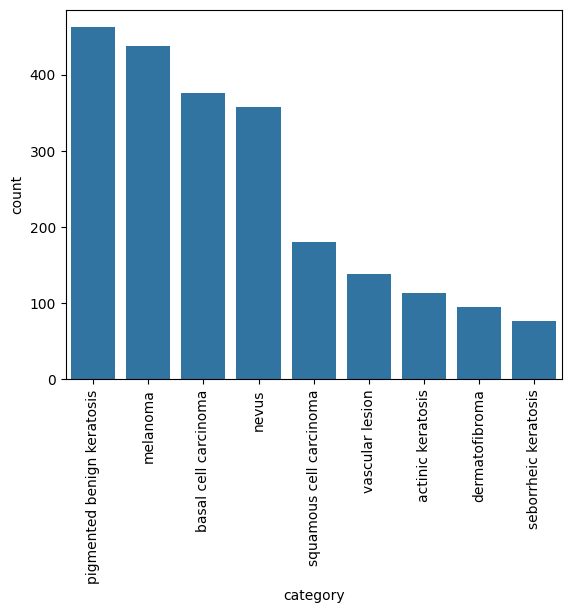

In [61]:
#plot counts of each type of class of images
categoryCounts = {}
for className in class_names:
  categoryCounts[className] = len(list(data_dir_train.glob(className + '/*.jpg')))
countData = pd.DataFrame(categoryCounts.items(), columns=['category','count']).sort_values(by='count',ascending=False)
sns.barplot(data=countData, x='category',y='count')
plt.xticks(rotation=90)
plt.show()

- From this barplot we can see that classes are imbalance. **Seborrheic keratosis** class has less than 100 samples. **Pigmented benign keratosis** and **melanoma** class has more than 400 samples. We need add more samples so that all classes are balanced in dataset.

#### Fix class imbalance

In [62]:
path_to_training_dataset=data_dir_train

for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEB3AE1A210>: 100%|██████████| 500/500 [00:23<00:00, 21.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEB3AEDE2D0>: 100%|██████████| 500/500 [00:24<00:00, 20.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEB3AD84450>: 100%|██████████| 500/500 [00:28<00:00, 17.65 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FEB3AF5BC50>: 100%|██████████| 500/500 [01:31<00:00,  5.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FEB3AD62090>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEB39CC7D10>: 100%|██████████| 500/500 [00:21<00:00, 23.11 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEB3B01AD10>: 100%|██████████| 500/500 [00:46<00:00, 10.69 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEB3AD61FD0>: 100%|██████████| 500/500 [00:30<00:00, 16.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEB3AF7F650>: 100%|██████████| 500/500 [00:30<00:00, 16.31 Samples/s]


In [64]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [65]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_35349a1c-3ab0-4722-bbc4-d08d64fdd674.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_8123589f-e7e1-48e3-b2eb-741ce41abebc.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_9becd9af-6865-401c-8a56-10ed3f699055.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_473d25b0-7054-4f46-b6ab-c8b905b6a7dd.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_a900c6a8-f975-40fd-98eb-0361fe840515.jpg']

In [66]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [68]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [69]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

### Distribution of augmented data after adding new images

In [70]:
df2['Label'].value_counts()

,count
Label,
actinic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500
vascular lesion,500
nevus,500


#### Train the model on the data created using Augmentor

In [71]:
# Load the dataset with new data
train_ds, val_ds, class_names,num_classes = load_datasets(data_dir_train,data_dir_test)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model using batch normalization

In [72]:
model = Sequential([augmentation_data,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16,(3,3), activation='relu', padding='same'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32,(3,3), activation='relu', padding='same'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile The model

In [73]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,969 (31.67 MB)

 Trainable params: 8,300,873 (31.67 MB)

 Non-trainable params: 96 (384.00 B)

In [74]:
# Train the model with 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.2289 - loss: 7.2908 - val_accuracy: 0.1143 - val_loss: 30.8894
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.3244 - loss: 1.8268 - val_accuracy: 0.1604 - val_loss: 13.9870
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.3602 - loss: 1.6751 - val_accuracy: 0.3229 - val_loss: 2.3515
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.3961 - loss: 1.5647 - val_accuracy: 0.2999 - val_loss: 2.2348
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.4093 - loss: 1.5665 - val_accuracy: 0.3638 - val_loss: 1.7284
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.4311 - loss: 1.4475 - val_accuracy: 0.3460 - val_loss: 2.3744
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.4667 - loss: 1.3764 - val_accuracy: 0.3987 - val_loss: 1.6093
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.4925 - loss: 1.2833 - val_ac

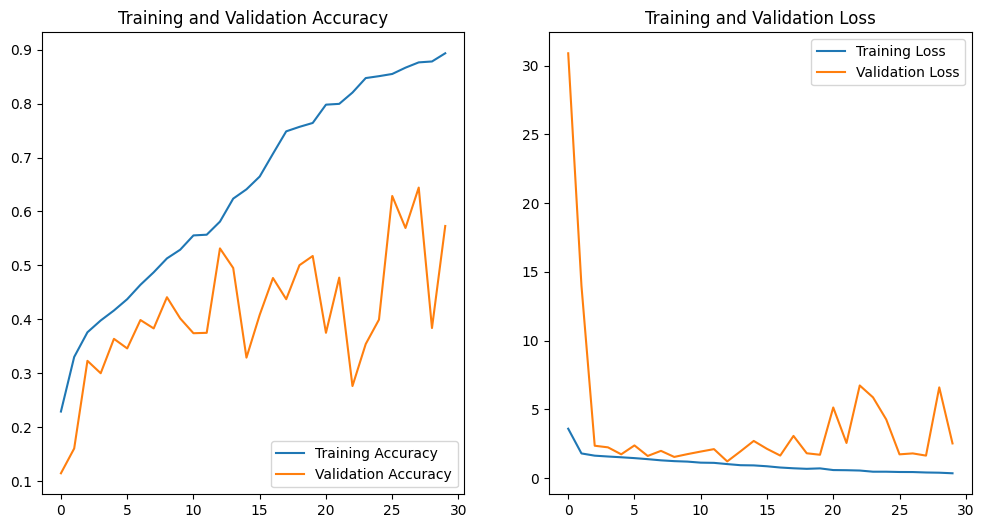

In [75]:
# Plot training performance
plot_accuracy_and_loss(history,epochs)

### Observations:

1) Training accuracy is evaluated to 89%

2) Validation accuracy is evaludated to 57%

3) There are several spikes in validation accuracy

4) Due to batch normalization training accuracy increased but validation accuracy is not increasing. This is an evidence of overfitting



## Creating another model (without batch normalization)

In [80]:
model = Sequential([augmentation_data,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])



In [81]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.1876 - loss: 3.0547 - val_accuracy: 0.3563 - val_loss: 1.6880
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.3952 - loss: 1.6135 - val_accuracy: 0.3979 - val_loss: 1.6170
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.4394 - loss: 1.4858 - val_accuracy: 0.4699 - val_loss: 1.4484
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.4809 - loss: 1.3651 - val_accuracy: 0.5093 - val_loss: 1.3725
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5125 - loss: 1.3027 - val_accuracy: 0.5130 - val_loss: 1.3061
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.5188 - loss: 1.2859 - val_accuracy: 0.5182 - val_loss: 1.2899
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5451 - loss: 1.2162 - val_accuracy: 0.5301 - val_loss: 1.2431
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5423 - loss: 1.1916 - val_accu

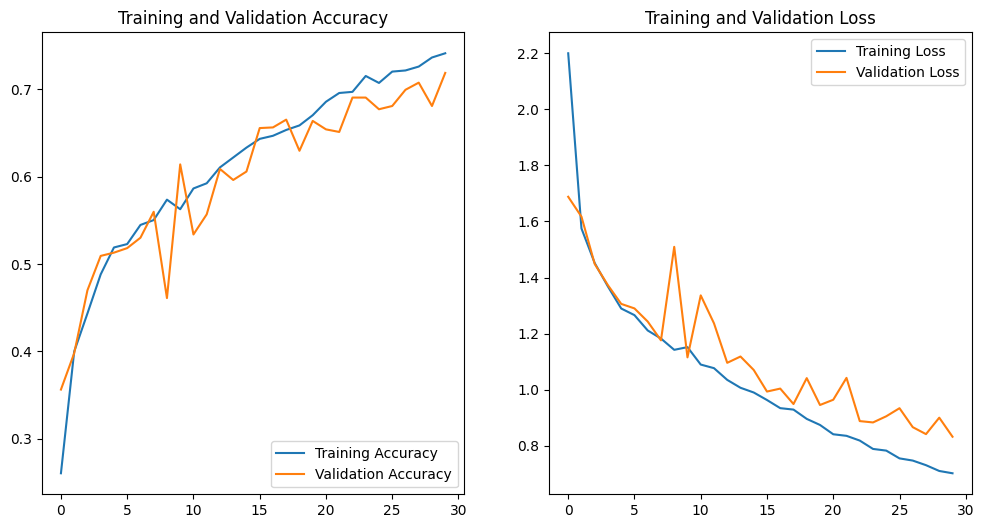

In [83]:
# Plot training performance
plot_accuracy_and_loss(history,epochs)

### Observations:

1) Model now has training accuracy of 73% and validation accuracy of 71.9%

2) The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

3) The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

4) Batch normalization was not able to improve  both training and validation accuracy.